<img align="left" src=https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=200 style="padding: 10px">
<br>
<b>AuxTel LATISS V&V Analysis Notebook</b> <br>
Contact author: Meredith Rawls<br>
Last verified to run: June 6, 2023<br>
LSST Science Piplines version: w_2023_22<br>
Container Size: Large <br>

# PREOPS-3429: Difference Imaging Analysis with AuxTel, first attempt

This is a reprocessing of the 2023-03B run, not the 2023-05A run as the ticket name suggested. I'm basing it off of the notes Huan left on [DM-39038](https://jira.lsstcorp.org/browse/DM-39038).

**Goal:** examine DIA data products (namely difference images and the DiaSources in them) resulting from the [LATISS DRP pipeline](https://github.com/lsst/drp_pipe/blob/main/pipelines/LATISS/DRP.yaml).

**Tracts processed:**

 * 1942 (patches 77-86, 96-105, 115-124, 134-143, 153-162, 172-181, 191-200, 210-219, 229-238, 256, 257)
 * 2786 (patches 43-46, 62-71, 81-90, 100-109, 119-129, 138-147, 157-167, 176-186, 195-205, 214-224, 233-241)
 * 10521 (patches 281, 282, 283, 300, 301, 302)
 
**Main takeaway:**

Processing through "Step 6" successfully happened, but the templates generated on-the-fly for each observing program are not scientifically useful. They only contain a handful of visits and are very shallow, so the resulting difference imaging is almost entirely noise. There is no real point in making light curves one night at a time. In the future, we will need to build templates using more visits over multiple nights instead of running template generation on a per-night basis prior to the rest of DIA.

## Table of Contents

1. [Imports and setup](#section_1)
2. [Inspect some DIA data products](#section_2)
3. [The most boring light curve](#section_3)
4. [Inspect some goodSeeingCoadds used in template generation](#section_4)
5. [Quick look at diaSources](#section_5)

## 1. <a id="section_1">Imports and setup</a>

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from astropy.coordinates import SkyCoord
import astropy.units as u
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import median_abs_deviation
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [3]:
import lsst.daf.butler as dafButler
from lsst.pex.config import Config
from lsst.pipe.base import Instrument

In [4]:
import lsst.afw.display as afwDisplay
import lsst.display.astrowidgets
afwDisplay.setDefaultBackend('astrowidgets')
#afwDisplay.setDefaultBackend('matplotlib')
import lsst.afw.display.rgb as afwRgb

In [5]:
repo = '/sdf/group/rubin/repo/embargo'
skymapName = 'latiss_v1'
instrument = 'LATISS'
collections = 'u/huanlin/LATISS/runs/AUXTEL_DRP_IMAGING_2023-03B/w_2023_17/DM-39038/all'
collectionStr = collections.replace("/", "_")
butler = dafButler.Butler(repo, collections=collections, skymap=skymapName)

## 2. <a id="section_2">Inspect some DIA data products</a>

We'll look at a difference image, a forcedSourceTable, and a sourceTable. Recall forcedSourceTables are per patch, while sourceTables are per visit+detector.

But first, how many templates (patches) and difference images (visit+detectors) are we actually dealing with in this collection?

In [6]:
butler.registry.queryDatasets('goodSeeingCoadd').count()

631

In [7]:
# This prints a long list of dataIds
#for coadd in butler.registry.queryDatasets('goodSeeingCoadd'):
#    print(coadd.dataId)

In [8]:
butler.registry.queryDatasets('goodSeeingDiff_differenceExp').count()

736

In [9]:
visitList = []
for diffim in butler.registry.queryDatasets('goodSeeingDiff_differenceExp'):
    visitList.append(diffim.dataId['visit'])
len(visitList)

736

### Inspect a randomly selected difference image

With the fun new astrowidgets afw backend!

In [11]:
visit = visitList[400]
detector = 0
diffim = butler.get('goodSeeingDiff_differenceExp', visit=visit, detector=detector)
display = afwDisplay.Display(dims=(500,500))
display.setMaskTransparency(50)
display.mtv(diffim)
display.embed()

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-6.0.0/Linux64/afw/ge482522685+44c69aaa44/python/lsst/afw/image/_exposureSummaryStats.py:157: FutureWarning: Could not read summary fields [decl]. Please use a newer stack.
  warnings.warn(


ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

### Cursory inspection of other DIA-related tables

We'll look at a single forcedSourceTable and a sourceTable for one of the most common visit+detectors therein.

I am used to doing everything with APDB queries, so this is partly an exercise in reminding myself how to get these things via the Butler.

In [61]:
tract=1942
patch=78
oneForcedSourceTable = butler.get('forcedSourceTable', collections=collections,
                            tract=tract, patch=patch,
                            skymap=skymapName, instrument=instrument)

In [13]:
oneForcedSourceTable.columns

Index(['objectId', 'parentObjectId', 'coord_ra', 'coord_dec', 'ccdVisitId',
       'band', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfDiffFlux',
       'psfDiffFluxErr', 'psfDiffFlux_flag', 'localPhotoCalib',
       'localPhotoCalib_flag', 'localPhotoCalibErr', 'localWcs_flag',
       'localWcs_CDMatrix_2_1', 'localWcs_CDMatrix_1_1',
       'localWcs_CDMatrix_1_2', 'localWcs_CDMatrix_2_2',
       'localBackground_instFlux', 'localBackground_instFluxErr',
       'pixelFlags_edge', 'pixelFlags_interpolated', 'pixelFlags_saturated',
       'pixelFlags_cr', 'pixelFlags_bad', 'pixelFlags_suspect',
       'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter',
       'pixelFlags_crCenter', 'pixelFlags_suspectCenter', 'tract', 'patch',
       'detect_isPrimary', 'detect_isTractInner', 'detect_isPatchInner'],
      dtype='object')

In [14]:
# TODO: rewrite this block with the new dataID packing system per DM-31924
instrumentDataId = butler.registry.expandDataId(instrument=instrument)
packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
dataId = packer.unpack(oneForcedSourceTable.ccdVisitId)
oneForcedSourceTable['visit'] = dataId['visit']
oneForcedSourceTable['detector'] = dataId['detector']

/tmp/ipykernel_4385/3057300529.py:3: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-6.0.0/Linux64/daf_butler/gef4fbc5b3d+7fe1ab1564/python/lsst/daf/butler/core/dimensions/_packer.py:242: FutureWarning: Call to deprecated class ObservationDimensionPacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  return self._cls(fixed, self._dimensions)


In [15]:
# TODO: use a block like this instead per DM-31924; it doesn't work yet
#class PlaceholderConfig(Config):
#    packer = Instrument.make_dimension_packer_config_field()
#config = PlaceholderConfig()
#packer = config.packer.apply(instrumentDataId, is_exposure=False)

#oneDataId = packer.unpack(oneForcedSourceTable.ccdVisitId.values[0])
#oneDataId

# goal...
#dataId = packer.unpack(oneForcedSourceTable.ccdVisitId)
#oneForcedSourceTable['visit'] = dataId['visit']
#oneForcedSourceTable['detector'] = dataId['detector']

In [16]:
oneForcedSourceTable

,objectId,parentObjectId,coord_ra,coord_dec,ccdVisitId,band,psfFlux,psfFluxErr,psfFlux_flag,psfDiffFlux,...,pixelFlags_saturatedCenter,pixelFlags_crCenter,pixelFlags_suspectCenter,tract,patch,detect_isPrimary,detect_isTractInner,detect_isPatchInner,visit,detector
forcedSourceId,,,,,,,,,,,,,,,,,,,,,
2121302278324355281,770911582698864641,0,90.393312,-53.256148,2023031500172,r,5958.061872,8567.212441,False,-3780.704463,...,False,False,False,1942,78,True,True,True,2023031500172,0
2121302278324355282,770911582698864642,0,90.322481,-53.255066,2023031500172,r,8219.372992,5836.941139,False,-2510.485902,...,False,False,False,1942,78,True,True,True,2023031500172,0
2121302278324355283,770911582698864643,0,90.437188,-53.252728,2023031500172,r,74785.624989,6730.420001,False,-2666.714215,...,False,False,False,1942,78,True,True,True,2023031500172,0
2121302278324355284,770911582698864644,0,90.445557,-53.252799,2023031500172,r,2353.236199,6300.993645,True,-1430.981274,...,False,False,False,1942,78,False,True,False,2023031500172,0
2121302278324355285,770911582698864645,0,90.314084,-53.253187,2023031500172,r,8897.564995,5827.141009,True,2035.209572,...,False,False,False,1942,78,True,True,True,2023031500172,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121302278325404273,770911582698865262,0,90.354549,-53.189787,2023031500173,g,2368.698183,4035.568683,True,-1566.020135,...,False,False,False,1942,78,False,True,True,2023031500173,0
2121302278325404274,770911582698865263,0,90.351891,-53.189086,2023031500173,g,797.654883,4018.962380,True,-1605.892525,...,False,False,False,1942,78,False,True,True,2023031500173,0
2121302278325404275,770911582698865264,0,90.361436,-53.186100,2023031500173,g,14496.768420,4076.583966,False,3442.676789,...,False,False,False,1942,78,False,True,True,2023031500173,0


In [17]:
oneForcedSourceTable_good = oneForcedSourceTable.loc[(oneForcedSourceTable['detect_isTractInner'] == True) & \
                                                     (oneForcedSourceTable['detect_isPatchInner'] == True) &\
                                                     (oneForcedSourceTable['detect_isPrimary'] == True)]

In [18]:
# Look at the existing combos of visit, detector, and band, and sort by most common
c = Counter(zip(oneForcedSourceTable_good['visit'],
                oneForcedSourceTable_good['detector'],
                oneForcedSourceTable_good['band']))
c.most_common()

[((2023031500172, 0, 'r'), 130),
 ((2023031500174, 0, 'g'), 130),
 ((2023031500171, 0, 'r'), 130),
 ((2023031500173, 0, 'g'), 130),
 ((2023031500176, 0, 'i'), 129),
 ((2023031500175, 0, 'i'), 129),
 ((2023031500165, 0, 'i'), 34),
 ((2023031500166, 0, 'i'), 34)]

### Select a visit+detector that appears frequently in this forcedSourceTable to load a sourceTable

In [19]:
# Manually use the same visit and detector as the test case above
visit = 2023031500172
detector = 0
oneSourceTable = butler.get('sourceTable', collections=collections,
                             tract=tract, patch=patch,
                             skymap=skymapName, instrument=instrument,
                             visit=visit, detector=detector)

In [20]:
oneSourceTable

,coord_ra,coord_dec,ccdVisitId,parentSourceId,x,y,xErr,yErr,ra,decl,...,hsmShapeRegauss_flag_galsim,hsmShapeRegauss_flag_no_pixels,hsmShapeRegauss_flag_not_contained,hsmShapeRegauss_flag_parent_source,sky_source,detect_isPrimary,visit,detector,band,physical_filter
sourceId,,,,,,,,,,,,,,,,,,,,,
2121302278324355073,90.437171,-53.252752,2023031500172,0,2970.908225,138.254079,0.760421,0.787734,90.437171,-53.252752,...,False,False,False,False,False,True,2023031500172,0,r,SDSSr_65mm~empty
2121302278324355074,90.384517,-53.250401,2023031500172,0,1787.000000,242.000000,NaN,NaN,90.384517,-53.250401,...,False,False,False,False,False,True,2023031500172,0,r,SDSSr_65mm~empty
2121302278324355075,90.466846,-53.249094,2023031500172,0,3640.655080,266.816776,0.340354,0.296306,90.466846,-53.249094,...,True,False,False,False,False,True,2023031500172,0,r,SDSSr_65mm~empty
2121302278324355076,90.425578,-53.245374,2023031500172,0,2713.672163,419.190426,0.959981,0.979622,90.425578,-53.245374,...,False,False,False,False,False,True,2023031500172,0,r,SDSSr_65mm~empty
2121302278324355077,90.403586,-53.245284,2023031500172,0,2218.688076,429.009724,1.778679,2.237280,90.403586,-53.245284,...,False,False,False,False,False,True,2023031500172,0,r,SDSSr_65mm~empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121302278324355248,90.408406,-53.178225,2023031500172,0,2360.000000,2950.000000,NaN,NaN,90.408406,-53.178225,...,True,False,False,False,True,False,2023031500172,0,r,SDSSr_65mm~empty
2121302278324355249,90.467558,-53.194661,2023031500172,0,3685.000000,2314.000000,NaN,NaN,90.467558,-53.194661,...,True,False,False,False,True,False,2023031500172,0,r,SDSSr_65mm~empty
2121302278324355250,90.436259,-53.223734,2023031500172,0,2965.000000,1230.000000,NaN,NaN,90.436259,-53.223734,...,False,False,False,False,True,False,2023031500172,0,r,SDSSr_65mm~empty


### Spatial crossmatch between sources and forced sources

In [21]:
forcedSourceCoords = SkyCoord(ra=oneForcedSourceTable_good.coord_ra.values*u.degree,
                              dec=oneForcedSourceTable_good.coord_dec.values*u.degree)
sourceCoords = SkyCoord(ra=oneSourceTable.coord_ra.values*u.degree, dec=oneSourceTable.coord_dec.values*u.degree)

In [22]:
idx, d2d, d3d = forcedSourceCoords.match_to_catalog_sky(sourceCoords)

In [23]:
# Only keep matches within 0.5 arcseconds
good_match = d2d < 0.5*u.arcsec
forcedSourceMatches = forcedSourceCoords[good_match]
sourceMatches = sourceCoords[idx[good_match]]

In [24]:
len(forcedSourceMatches)

276

In [25]:
len(d2d)

846

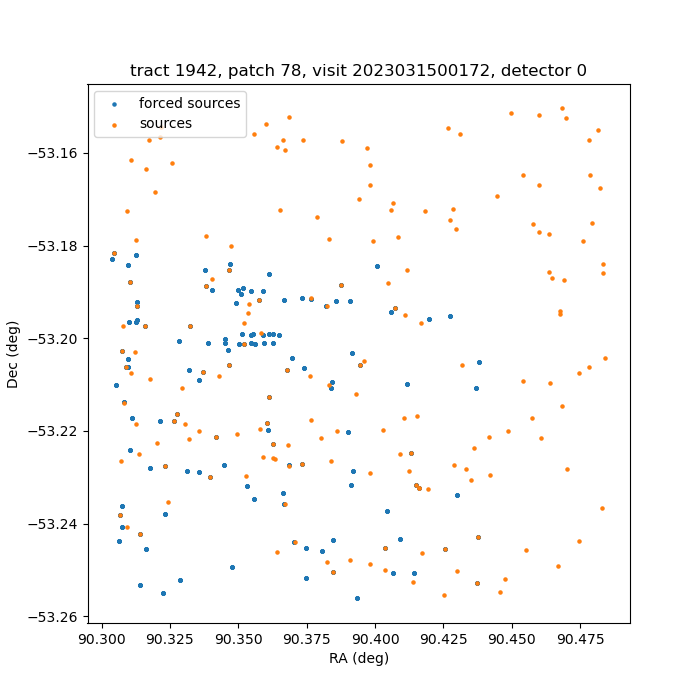

In [26]:
plt.figure(figsize=(7,7))
plt.scatter(oneForcedSourceTable_good.coord_ra, oneForcedSourceTable_good.coord_dec, s=5, label='forced sources')
plt.scatter(oneSourceTable.coord_ra, oneSourceTable.coord_dec, s=5, label='sources')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title(f'tract {tract}, patch {patch}, visit {visit}, detector {detector}')
plt.legend()

The blue forced sources are PVI fluxes at the locations of all detected objects (one patch only) . The orange sources sources are detections in one PVI. The patch chosen for this forcedSourceTable and the visit chosen for this sourceTable do not fully overlap.

## 3. <a id="section_3">The most boring light curve</a>

It is boring because this collection is just for one night, and there was not a lot of revisiting of the same sources happening.

There is only data in the g, r, and i bands.

In [27]:
def color_assigner(band):
    colorDict = {'u': 'C0', 'g': 'C2', 'r': 'C1', 'i': 'C3', 'z': 'C4', 'y': 'k'}
    return colorDict[band]

def ax_assigner(band):
    axDict = {'u': [0,0], 'g': [0,1], 'r': [1,0], 'i': [1,1], 'z': [2,0], 'y': [2,1]}
    return axDict[band]

In [28]:
oneCcdVisitTable = butler.get('ccdVisitTable', collections=collections,
                                tract=tract, patch=patch,
                                skymap=skymapName, instrument=instrument)

In [29]:
oneObjectTable = butler.get('objectTable', collections=collections,
                              tract=tract, patch=patch, skymap=skymapName, instrument=instrument)

In [30]:
oneForcedSourceTable['forcedSourceId'] = oneForcedSourceTable.index
oneForcedSourceTable = pd.merge(oneForcedSourceTable, oneCcdVisitTable['expMidpt'], on='ccdVisitId', how='left').set_index('forcedSourceId')

In [31]:
oneForcedSourceTable_good = oneForcedSourceTable.loc[(oneForcedSourceTable['detect_isTractInner'] == True) & \
                                (oneForcedSourceTable['detect_isPatchInner'] == True)]

In [32]:
objectList = list(set(oneForcedSourceTable_good.objectId))
print(len(objectList))

318


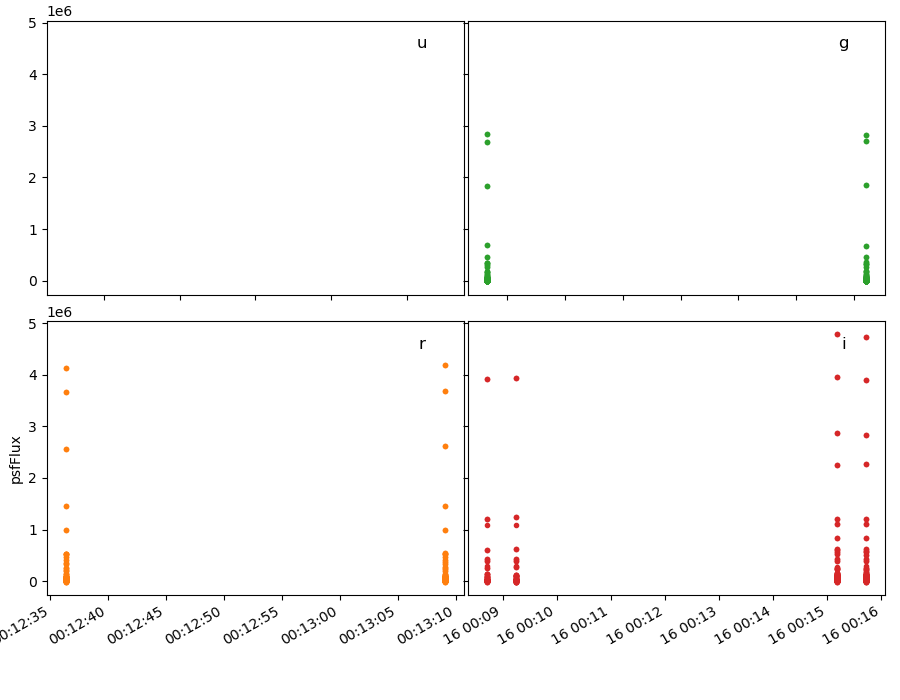

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(9,7), sharey=True)
fig.autofmt_xdate()
fig.tight_layout()

for obj in objectList:  # CAREFUL, this is a lot of objects without indexing
    rows = oneForcedSourceTable_good.loc[oneForcedSourceTable_good.objectId == obj]
    for band in ['u', 'g', 'r', 'i']:
        axIdx = tuple(ax_assigner(band))
        color = color_assigner(band)
        data = rows.loc[rows['band'] == band]
        axs[axIdx].errorbar(data.expMidpt, data.psfFlux, yerr=data.psfFluxErr, marker='.', ls='None',
                            color=color, label=obj)
        axs[axIdx].set_title(band, x=0.9, y=1.0, pad=-20)
        axs[axIdx].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        if band == 'r':
            axs[axIdx].set_ylabel('psfFlux')

plt.subplots_adjust(bottom=0.15, wspace=0.01)

In [34]:
print(min(oneForcedSourceTable_good['expMidpt']), max(oneForcedSourceTable_good['expMidpt']))

2023-03-16 00:08:42.587498 2023-03-16 00:15:43.009505


Note the elapsed time is less than one hour!

In [35]:
def analyzeObjectLc(obj, df, doPlot=False, printStats=False):
    """obj should be an objectId
    df should be a forcedSourceTable with columns `expMidpt`, `psfFlux`, `psfFluxErr`, and `band`.
    """
    rows = df.loc[df.objectId == obj]
    rows = rows.sort_values(by=['expMidpt'])
    #colors = list(map(color_assigner, rows.band))
    if doPlot:
        fig, ax = plt.subplots(1,1, figsize=(9,4))
        fig.autofmt_xdate()
        ax.set_title('objectId ' + str(rows.index[0]))
    if printStats:
        print('band nobs CV MAD')
        print('----------------')
    cvList = []
    madList = []
    for band in ['g', 'r', 'i']:
        npoints = len(rows.loc[rows['band'] == band])
        times = rows.loc[rows['band'] == band, 'expMidpt']
        fluxes = rows.loc[rows['band'] == band, 'psfFlux']
        fluxerrs = rows.loc[rows['band'] == band, 'psfFluxErr']
        # compute weighted coefficient of variation
        dsw = DescrStatsW(fluxes, 1./fluxerrs)  # descriptive statistics and tests with weights for case weights
        cv = dsw.std / np.abs(dsw.mean)  # weighted std / absolute value of weighted mean
        cvList.append(cv)
        # compute median absolute deviation
        mad = median_abs_deviation(fluxes)  # THIS DOES NOT USE THE FLUXERRS!!!
        madList.append(mad)
        if printStats:
            print(f'{band} {npoints} {cv:4.3f} {mad:5.2f}')
        if doPlot:
            color = color_assigner(band)
            ax.errorbar(times, fluxes, yerr=fluxerrs, marker='o', color=color, ms=4, ls=':', label=band)
    if doPlot:
        plt.legend()
        plt.ylabel('Flux')
    return cvList, madList

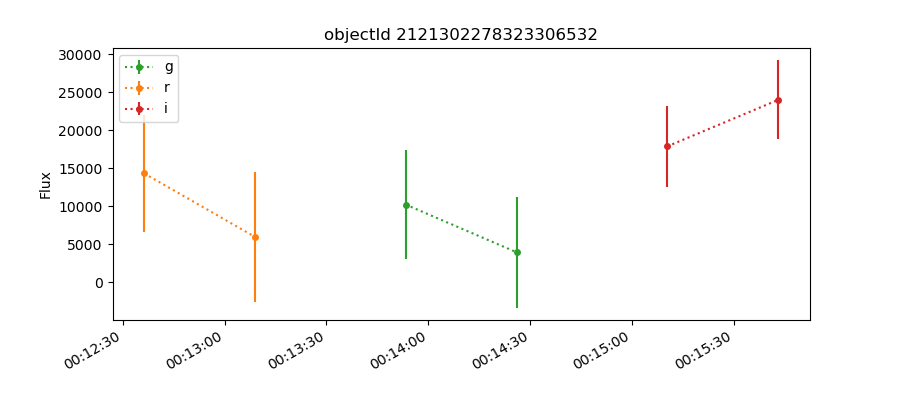

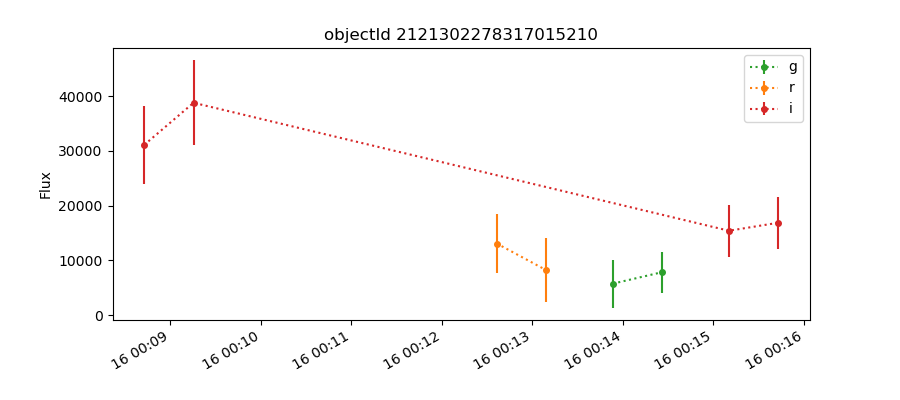

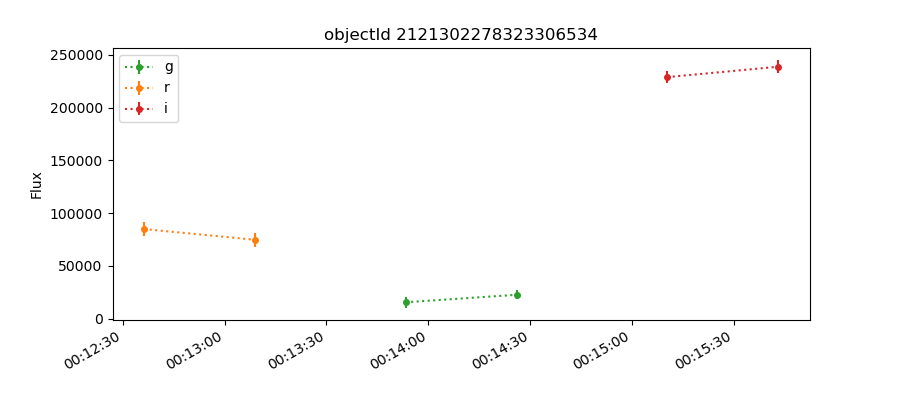

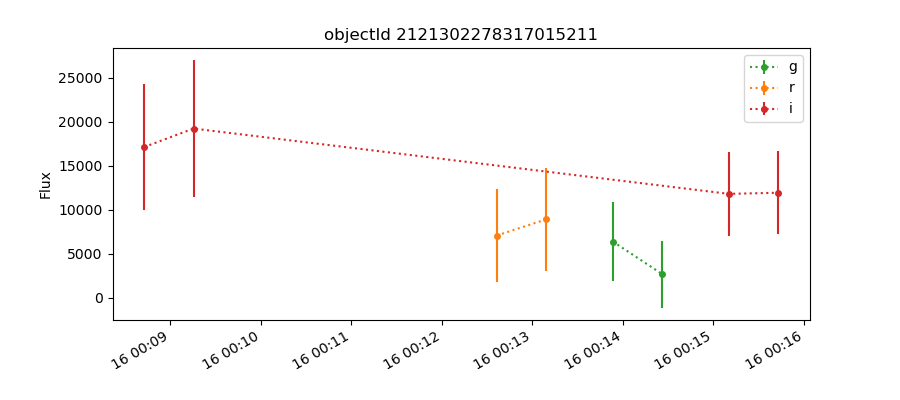

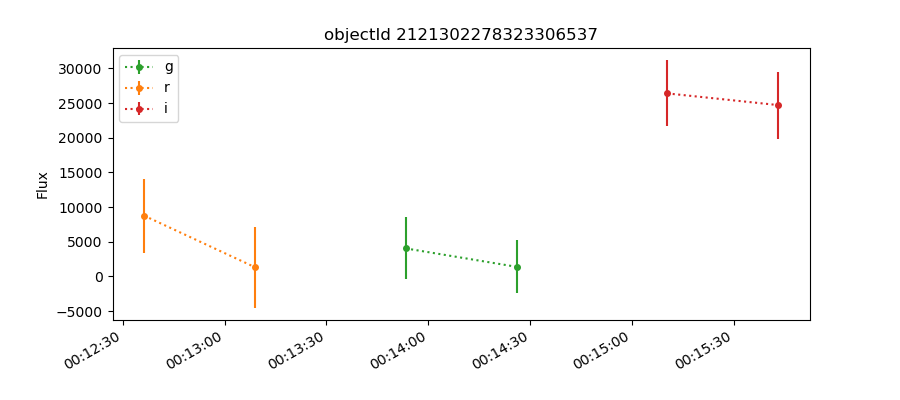

In [36]:
for obj in objectList[0:5]:
    result = analyzeObjectLc(obj, oneForcedSourceTable_good, doPlot=True, printStats=False)

## 4. <a id="section_4">Inspect some goodSeeingCoadds used in template generation</a>

The difference images look to be mostly full of noise, and looking at the templates might help us understand why.

The function `buildTractImage` is kindly borrowed from Lauren.

In [37]:
def buildTractImage(butler, tract, patchList=None, coaddName="deep", collection=None):
    """Build up an image of an entire tract or list of patches.

    Parameters
    ----------
    butler : `lsst.daf.butler.Butler`
        The butler associated with the data of interest.
    skymap : `lsst.skymap.ringsSkyMap.RingsSkyMap`
        Tract information object.
    patchList : `list` [`str`], optional
        A list of the patches to include.  If `None`, the full list of patches
        in ``tract`` will be included.
    coaddName : `str`, optional
        The base name of the coadd (e.g. "deep" or "goodSeeing").

    Raises
    ------
    RuntimeError
        If ``nPatches`` is zero, i.e. no data were found.

    Returns
    -------
    image : `lsst.afw.image.ImageF`
        The full tract or patches in ``patchList`` image.
    """
    xMin, yMin = 1e12, 1e12
    xMax, yMax = -1e12, -1e12

    # YOU MAY WANT TO CHANGE THESE!
    vMin, dataRange, Q = 0.5, 8, 5
    # vMin, dataRange, Q = 0.1, 3, 2  # YOU MAY WANT TO CHANGE THESE!

    skymap = butler.get("skyMap")
    tractInfo = skymap[tract]
    tractBbox = tractInfo.getBBox()

    nPatches = 0
    patchesFoundList = []
    if not patchList:
        patchList = []
        for patch in tractInfo:
            patchList.append(patch.getSequentialIndex())
    tractArray = np.full((tractBbox.getMaxY() + 1, tractBbox.getMaxX() + 1, 3), np.nan, dtype="uint8")
    print("len(tractArray) = ", len(tractArray.ravel()))
    for patch in patchList:        
        dataIdI = {"patch": patch, "tract": tract, "band": "i"} 
        dataIdR = {"patch": patch, "tract": tract, "band": "r"} 
        dataIdG = {"patch": patch, "tract": tract, "band": "g"}
        try:
            coaddI = butler.get(coaddName + "Coadd", dataIdI)
            coaddR = butler.get(coaddName + "Coadd", dataIdR)
            coaddG = butler.get(coaddName + "Coadd", dataIdG)
        except LookupError:
            print("patch {} not found in {}".format(patch, collection))
            continue
        patchesFoundList.append(patch)

        coaddRgb = afwRgb.makeRGB(coaddI, coaddR, coaddG, minimum=vMin, dataRange=dataRange, Q=Q)
        bbox = coaddI.getBBox()
        xMin = max(0, min(xMin, bbox.getMinX()))
        xMax = min(tractBbox.getMaxX(), max(xMax, bbox.getMaxX()))
        yMin = max(0, min(yMin, bbox.getMinY()))
        yMax = min(tractBbox.getMaxY(), max(yMax, bbox.getMaxY()))

        # Account for edge patches that extend beyond tract boundaries
        edgeDeltaMinX = bbox.getMinX() - tractBbox.getMinX()
        edgeDeltaMaxX = -(bbox.getMaxX() - tractBbox.getMaxX())
        edgeDeltaMinY = bbox.getMinY() - tractBbox.getMinY()
        edgeDeltaMaxY = -(bbox.getMaxY() - tractBbox.getMaxY())
        coaddMinX = 0 if edgeDeltaMinX >=0 else -edgeDeltaMinX
        coaddMaxX = bbox.getWidth() + edgeDeltaMaxX if edgeDeltaMaxX < 0 else bbox.getWidth()
        coaddMinY = 0 if edgeDeltaMinY >=0 else -edgeDeltaMinY
        coaddMaxY = bbox.getHeight() + edgeDeltaMaxY if edgeDeltaMaxY < 0 else bbox.getHeight()

        coaddTractMinX = max(tractBbox.getMinX(), bbox.getMinX())
        coaddTractMaxX = min(tractBbox.getMaxX(), bbox.getMaxX())
        coaddTractMinY = max(tractBbox.getMinY(), bbox.getMinY())
        coaddTractMaxY = min(tractBbox.getMaxY(), bbox.getMaxY())

        xPad = 0 if coaddMinX == 0 else 1
        yPad = 0 if coaddMinY == 0 else 1
        tractArray[coaddTractMinY:coaddTractMaxY + 1,
                   coaddTractMinX:coaddTractMaxX + 1, :] = coaddRgb[coaddMinY:coaddMaxY + yPad,
                                                                    coaddMinX:coaddMaxX + xPad,
                                                                    :]
        nPatches += 1
    print("Tract coverage of patches: xMin, xMax, yMin, yMax", xMin, xMax, yMin, yMax)
    if nPatches == 0:
        raise RuntimeError("No data found for tract {}".format(tractInfo.getId()))
    trimmedArray = tractArray[yMin:yMax, xMin:xMax, :]
    print("len(trimedArray) = ", len(trimmedArray.ravel()))

    return trimmedArray, patchesFoundList, xMin, yMin

In [38]:
def addPatchOutlines(ax, tractInfo, patchesFoundList, xOff, yOff):
    patches = []
    for patch in tractInfo:
        if patch.sequential_index in patchesFoundList:
            corners = [(c.getX() - xOff, c.getY() - yOff) for c in patch.getInnerBBox().getCorners()]
            patches.append(Polygon(corners, fill=False, color=None, edgecolor="teal", facecolor=None, closed=True))
            center = patch.getInnerBBox().getCenter()
            text = patch.sequential_index
            cLab = "teal"
            ax.text(center.getX() - xOff, center.getY() - yOff, text,
                    ha="center", va="center", size=7, color=cLab)
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)

In [39]:
tract = 1942
patchList = [77, 78, 79, 80, 81, 82, 83, 84, 85, 96, 97, 98]
# The following can take a while...
tractRgbArray, patchesFoundList, xOff, yOff = buildTractImage(butler=butler, tract=tract,
                                                              patchList=patchList,
                                                              coaddName="goodSeeing",
                                                              collection=collections,
                                                              )

len(tractArray) =  9747000000
Tract coverage of patches: xMin, xMax, yMin, yMax 2800 30199 11800 18199
len(trimedArray) =  525978603


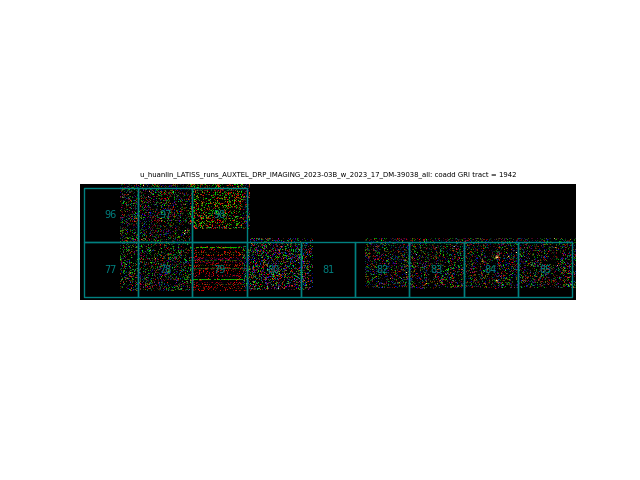

In [40]:
fig, axCoadd = plt.subplots(1, 1)
plt.axis("off")
imCoadd = axCoadd.imshow(tractRgbArray, interpolation="nearest", origin="lower")
fontDict = {"fontsize": 5}
axCoadd.set_title("{}: coadd GRI tract = {}".format(collectionStr, tract), fontdict=fontDict)
skymap = butler.get("skyMap")
tractInfo = skymap[tract]
addPatchOutlines(axCoadd, tractInfo, patchesFoundList, xOff, yOff)
#if doSaveFig:
#    filename = "{}{}_coaddRgb_{}_{}".format(saveDir, camera.getName(), tract, collectionStr)
#    print("Saving file in: {}".format(filename))
#    fig.savefig(filename)

In [41]:
patchesFoundList

[77, 78, 79, 80, 81, 82, 83, 84, 85, 96, 97, 98]

### Just how many constituent visits are in these shallow "goodSeeing" coadds anyway?

In [42]:
def coaddInspect(tract, patch, band):
    coaddInputs = butler.get("goodSeeingCoadd.coaddInputs", tract=tract, patch=patch, band=band)
    print(tract, patch, band, len(coaddInputs.visits['id']))

In [43]:
for patch in patchesFoundList:
    for band in ['g', 'r', 'i']:
        coaddInspect(1942, patch, band)

1942 77 g 2
1942 77 r 2
1942 77 i 2
1942 78 g 2
1942 78 r 2
1942 78 i 4
1942 79 g 4
1942 79 r 4
1942 79 i 6
1942 80 g 2
1942 80 r 2
1942 80 i 4
1942 81 g 2
1942 81 r 2
1942 81 i 2
1942 82 g 2
1942 82 r 2
1942 82 i 2
1942 83 g 4
1942 83 r 4
1942 83 i 4
1942 84 g 4
1942 84 r 4
1942 84 i 4
1942 85 g 4
1942 85 r 4
1942 85 i 4
1942 96 g 4
1942 96 r 4
1942 96 i 4
1942 97 g 6
1942 97 r 6
1942 97 i 6
1942 98 g 6
1942 98 r 6
1942 98 i 6


## 5. <a id="section_5">Quick look at diaSources</a>

There don't appear to be any diaObjectTables (or similarly-named things) in this collection.

In [76]:
# We previously determined this visit + detector falls mostly inside this tract + patch
visit = 2023031500172
detector = 0
tract = 1942
patch = 78

In [77]:
oneDiaSourceTable = butler.get('diaSourceTable', collections=collections, visit=visit)

In [78]:
oneDiaSourceTable.columns

Index(['diaSourceId', 'ccdVisitId', 'filterName', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midPointTai', 'bboxSize', 'ra', 'decl', 'x', 'y',
       'xErr', 'yErr', 'apFlux', 'apFluxErr', 'snr', 'psFlux', 'psFluxErr',
       'psChi2', 'psNdata', 'trailFlux', 'trailRa', 'trailDecl', 'trailLength',
       'trailAngle', 'dipMeanFlux', 'dipMeanFluxErr', 'dipFluxDiff',
       'dipFluxDiffErr', 'dipLength', 'dipAngle', 'dipChi2', 'isDipole',
       'totFlux', 'totFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF',
       'ixyPSF', 'pixelFlags', 'pixelFlags_offimage', 'pixelFlags_edge',
       'pixelFlags_interpolated', 'pixelFlags_saturated', 'pixelFlags_cr',
       'pixelFlags_bad', 'pixelFlags_suspect', 'pixelFlags_interpolatedCenter',
       'pixelFlags_saturatedCenter', 'pixelFlags_crCenter',
       'pixelFlags_suspectCenter', 'centroid_flag', 'centroid_pos_flag',
       'centroid_neg_flag', 'apFlux_flag', 'apFlux_flag_apertureTruncated',
       'psfFlux_flag', 'psfFlux_fl

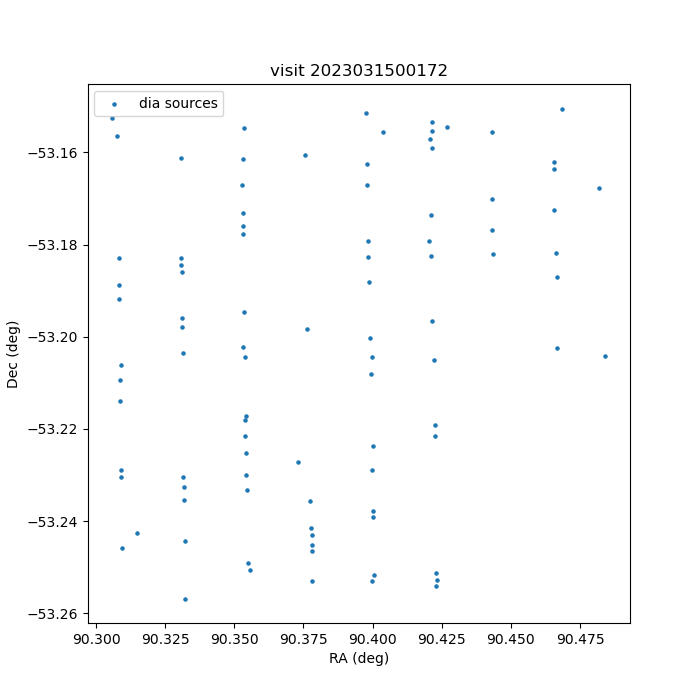

In [79]:
plt.figure(figsize=(7,7))
plt.scatter(oneDiaSourceTable.ra, oneDiaSourceTable.decl, s=5, label='dia sources')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title(f'visit {visit}')
plt.legend()

In [102]:
butler.registry.queryDatasets('objectTable').count()  # regular objects, not diaObjects

211

In [100]:
oneObjectTable = butler.get('objectTable', collections=collections,
                            tract=tract, patch=patch,
                            skymap=skymapName, instrument=instrument)

In [81]:
oneObjectTable.columns

Index(['detect_isPrimary', 'merge_peak_sky', 'detect_isDeblendedModelSource',
       'detect_isPatchInner', 'coord_dec', 'ebv', 'shape_xx', 'xErr',
       'xy_flag', 'deblend_nChild',
       ...
       'r_kronFlux_flag', 'r_kronFlux_flag_bad_radius',
       'r_kronFlux_flag_bad_shape', 'r_kronFlux_flag_bad_shape_no_psf',
       'r_kronFlux_flag_edge', 'r_kronFlux_flag_no_fallback_radius',
       'r_kronFlux_flag_no_minimum_radius', 'r_kronFlux_flag_small_radius',
       'r_kronFlux_flag_used_minimum_radius',
       'r_kronFlux_flag_used_psf_radius'],
      dtype='object', name='column', length=510)

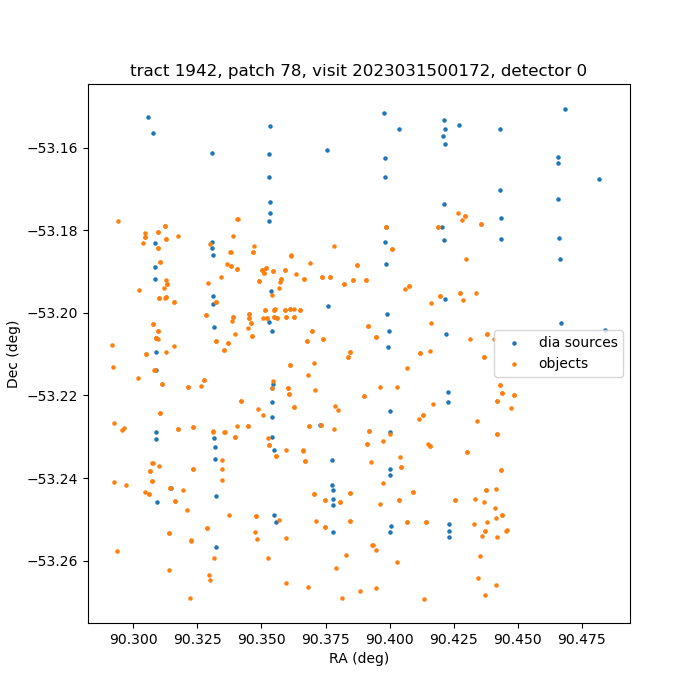

In [82]:
plt.figure(figsize=(7,7))
plt.scatter(oneDiaSourceTable.ra, oneDiaSourceTable.decl, s=5, label='dia sources', color='C0')
plt.scatter(oneObjectTable.coord_ra, oneObjectTable.coord_dec, s=5, label='objects', color='C1')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title(f'tract {tract}, patch {patch}, visit {visit}, detector {detector}')
plt.legend()

### diaSources from more than one visit

In [101]:
butler.registry.queryDatasets('diaSourceTable').count()

736

In [89]:
visit = 2023031500172
miniVisitList = range(visit, visit+100)

There is no visit 2023031500177, skipping it
There is no visit 2023031500185, skipping it
There is no visit 2023031500227, skipping it
There is no visit 2023031500269, skipping it


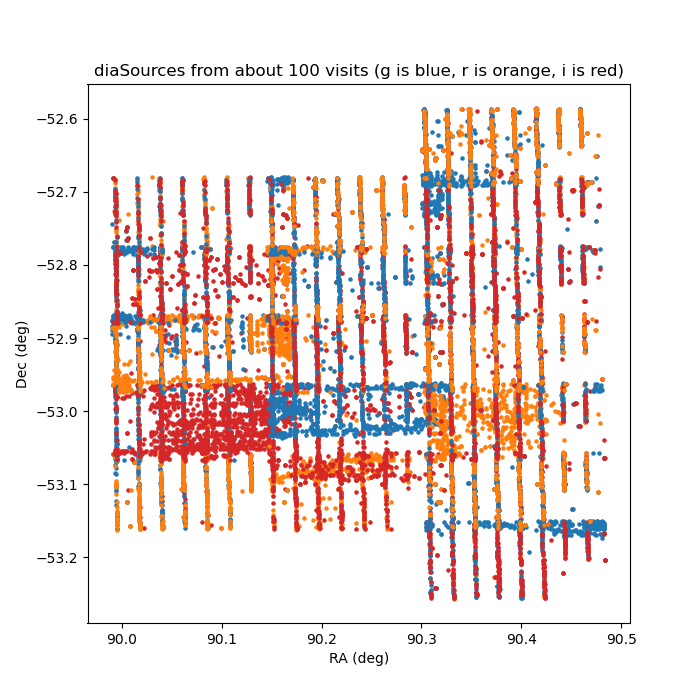

In [97]:
plt.figure(figsize=(7,7))
plt.title('diaSources from about 100 visits (g is blue, r is orange, i is red)')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
for visit in miniVisitList:
    try:
        oneDiaSourceTable = butler.get('diaSourceTable', collections=collections, visit=visit)
    except LookupError:
        print(f'There is no visit {visit}, skipping it')
        continue
    else:
        if oneDiaSourceTable.filterName[0] == 'g':
            color = 'C0'  # blue
        elif oneDiaSourceTable.filterName[0] == 'r':
            color = 'C1'  # orange
        elif oneDiaSourceTable.filterName[0] == 'i':
            color = 'C3'  # red
        else:
            color = '0.75'  # gray
        plt.scatter(oneDiaSourceTable.ra, oneDiaSourceTable.decl, s=5, color=color)